In [1]:
import pickle as pkl
import time
import os
import numpy as np
import sys
from music21 import instrument, note, stream, chord, duration
from models.RNNAttention import create_network, sample_with_temp

import matplotlib.pyplot as plt


Using TensorFlow backend.


# parameters

In [8]:
# run params
section = 'compose'
run_id = 'baseline'
genre_name = 'jazz'
composer_name='ChetBaker'

run_folder = 'run/{}/{}/'.format(section, genre_name)
run_folder += '_'.join([run_id, composer_name])

# model params
embed_size = 100
rnn_units = 16
use_attention = True

mode = 'load' # 'load' # 


## load the lookup tables

In [9]:

store_folder = os.path.join(run_folder, 'store')

with open(os.path.join(store_folder, 'distincts'), 'rb') as filepath:
    distincts = pkl.load(filepath)
    note_names, n_notes, duration_names, n_durations = distincts

with open(os.path.join(store_folder, 'lookups'), 'rb') as filepath:
    lookups = pkl.load(filepath)
    note_to_int, int_to_note, duration_to_int, int_to_duration = lookups

## build the model

In [10]:
weights_folder = os.path.join(run_folder, 'weights')
weights_file = 'weights.h5'

model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)

# Load the weights to each node
weight_source = os.path.join(weights_folder,weights_file)
model.load_weights(weight_source)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 100)    7200        input_5[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 100)    2500        input_6[0][0]                    
____________________________________________________________________________________________

## build your own phrase

In [11]:
# prediction params
notes_temp=0.5
duration_temp = 0.5
max_extra_notes = 200
max_seq_len = 32
seq_len = 8

#notes = ['START', 'D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3']
#durations = [0, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2]


#notes = ['START', 'F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3','F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3']
#durations = [0, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2]


notes = ['START']
durations = [0]

#if seq_len is not None:
#    notes = ['START'] * (seq_len - len(notes)) + notes
#    durations = [0] * (seq_len - len(durations)) + durations

if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            #notes.extend(['START'] * seq_len)
            #durations.extend([0]* seq_len)
            notes.extend(['START'])
            durations.extend([0])

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pkl.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pkl.dump(durations, f)
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pkl.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pkl.load(f) 

notes = notes[0:seq_len]
durations = durations[0:seq_len]
    
    
sequence_length = len(notes)

In [12]:
print(notes)

['START', 'C5', 'D5', 'C5', 'E5', 'C5', 'D5', 'C5.D5']


## Generate notes from the neural network based on a sequence of notes

In [13]:
prediction_output = []
notes_input_sequence = []
durations_input_sequence = []

overall_preds = []

for n, d in zip(notes,durations):
    note_int = note_to_int[n]
    duration_int = duration_to_int[d]
    
    notes_input_sequence.append(note_int)
    durations_input_sequence.append(duration_int)
    
    prediction_output.append([n, d])
    
    if n != 'START':
        if ('.' in n):
            print(n)
            notes_in_chord = n.split('.')
            chord_notes = []
            for current_note in notes_in_chord:
                single_note = note.Note(current_note)
                chord_notes.append(single_note)
                midi_chord = chord.Chord(chord_notes)
                new_note = np.zeros(128)
                for p in midi_chord.pitches:
                    new_note[p.midi] = 1
                overall_preds.append(new_note)
                
        else:           
            midi_note = note.Note(n)
            new_note = np.zeros(128)
            new_note[midi_note.pitch.midi] = 1
            overall_preds.append(new_note)

att_matrix = np.zeros(shape = (max_extra_notes+sequence_length, max_extra_notes))

for note_index in range(max_extra_notes):

    prediction_input = [
        np.array([notes_input_sequence])
        , np.array([durations_input_sequence])
       ]

    notes_prediction, durations_prediction = model.predict(prediction_input, verbose=0)
    if use_attention:
        att_prediction = att_model.predict(prediction_input, verbose=0)[0]
        att_matrix[(note_index-len(att_prediction)+sequence_length):(note_index+sequence_length), note_index] = att_prediction
    
    new_note = np.zeros(128)
    
    for idx, n_i in enumerate(notes_prediction[0]):
        try:
            note_name = int_to_note[idx]
            midi_note = note.Note(note_name)
            new_note[midi_note.pitch.midi] = n_i
            
        except:
            pass
        
    overall_preds.append(new_note)
            
    
    i1 = sample_with_temp(notes_prediction[0], notes_temp)
    i2 = sample_with_temp(durations_prediction[0], duration_temp)
    

    note_result = int_to_note[i1]
    duration_result = int_to_duration[i2]
    
    prediction_output.append([note_result, duration_result])

    notes_input_sequence.append(i1)
    durations_input_sequence.append(i2)
    
    if len(notes_input_sequence) > max_seq_len:
        notes_input_sequence = notes_input_sequence[1:]
        durations_input_sequence = durations_input_sequence[1:]
        
#     print(note_result)
#     print(duration_result)
        
    if note_result == 'START':
        break

overall_preds = np.transpose(np.array(overall_preds)) 
print('Generated sequence of {} notes'.format(len(prediction_output)))

C5.D5
Generated sequence of 208 notes


In [14]:
print(prediction_output)

[['START', 0], ['C5', 0.5], ['D5', 0.5], ['C5', 0.5], ['E5', 0.5], ['C5', Fraction(1, 3)], ['D5', Fraction(1, 3)], ['C5.D5', Fraction(1, 6)], ['E4.F4', Fraction(1, 3)], ['G3', 0.5], ['F4', Fraction(5, 12)], ['B3', 0.5], ['E-4', 0.5], ['D4', Fraction(1, 6)], ['D4', 0.5], ['E4', Fraction(1, 6)], ['D4', 0.5], ['E4', 0.5], ['E4', 0.5], ['F4', 0.5], ['D4', 0.5], ['F4', 0.5], ['F4', 0.5], ['B-4', 0.5], ['D4', 0.5], ['D4', 0.5], ['A4', 0.5], ['F4', 0.5], ['B-4', 0.5], ['D4', 0.5], ['A4', 0.5], ['E-4', 0.5], ['F4', 0.25], ['F#4', 0.25], ['G4', 0.25], ['A4', 0.25], ['G4', 0.25], ['A4', 0.25], ['A4', 0.25], ['A4', 0.5], ['A4', 0.5], ['D4', 0.5], ['F4', 0.25], ['F4', 0.25], ['F4', 0.25], ['F4', 0.25], ['G4', 0.25], ['G4', 0.25], ['A4', 0.25], ['C4', 0.25], ['G4', 0.25], ['G4', Fraction(1, 6)], ['C4', 0.25], ['G4', 0.25], ['D4', 0.25], ['E-4', 0.25], ['G4', 0.25], ['G4', 0.25], ['F4', 0.25], ['G4', 0.25], ['G4', 0.25], ['G4', 0.25], ['D4', 0.25], ['D4', 0.25], ['C5', 0.5], ['E4', 0.5], ['C5', 0.5]

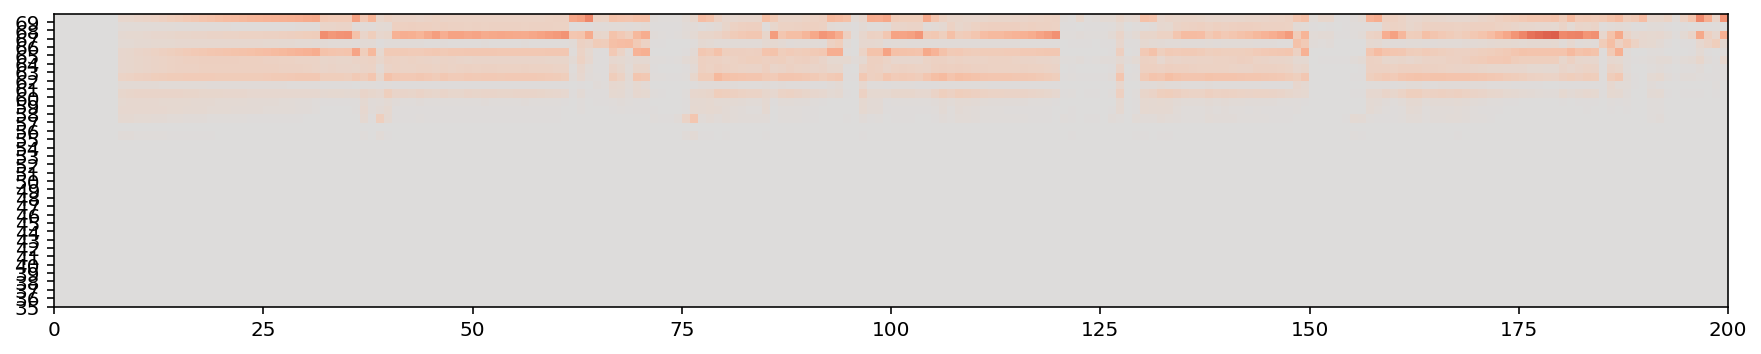

In [15]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_yticks([int(j) for j in range(35,70)])

plt.imshow(overall_preds[35:70,:], origin="lower", cmap='coolwarm', vmin = -0.5, vmax = 0.5, extent=[0, max_extra_notes, 35,70]
          
          )

## convert the output from the prediction to notes and create a midi file from the notes 

In [16]:
output_folder = os.path.join(run_folder, 'output')

midi_stream = stream.Stream()

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    note_pattern, duration_pattern = pattern
    # pattern is a chord
    if ('.' in note_pattern):
        notes_in_chord = note_pattern.split('.')
        chord_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(current_note)
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Violoncello()
            chord_notes.append(new_note)
        new_chord = chord.Chord(chord_notes)
        midi_stream.append(new_chord)
    elif note_pattern == 'rest':
    # pattern is a rest
        new_note = note.Rest()
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)
    elif note_pattern != 'START':
    # pattern is a note
        new_note = note.Note(note_pattern)
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)



midi_stream = midi_stream.chordify()
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write('midi', fp=os.path.join(output_folder, 'output-' + timestr + '.mid'))

'run/compose/jazz/baseline_ChetBaker/output/output-20191204-011151.mid'

In [17]:
print(new_chord)

<music21.chord.Chord E4 F4>


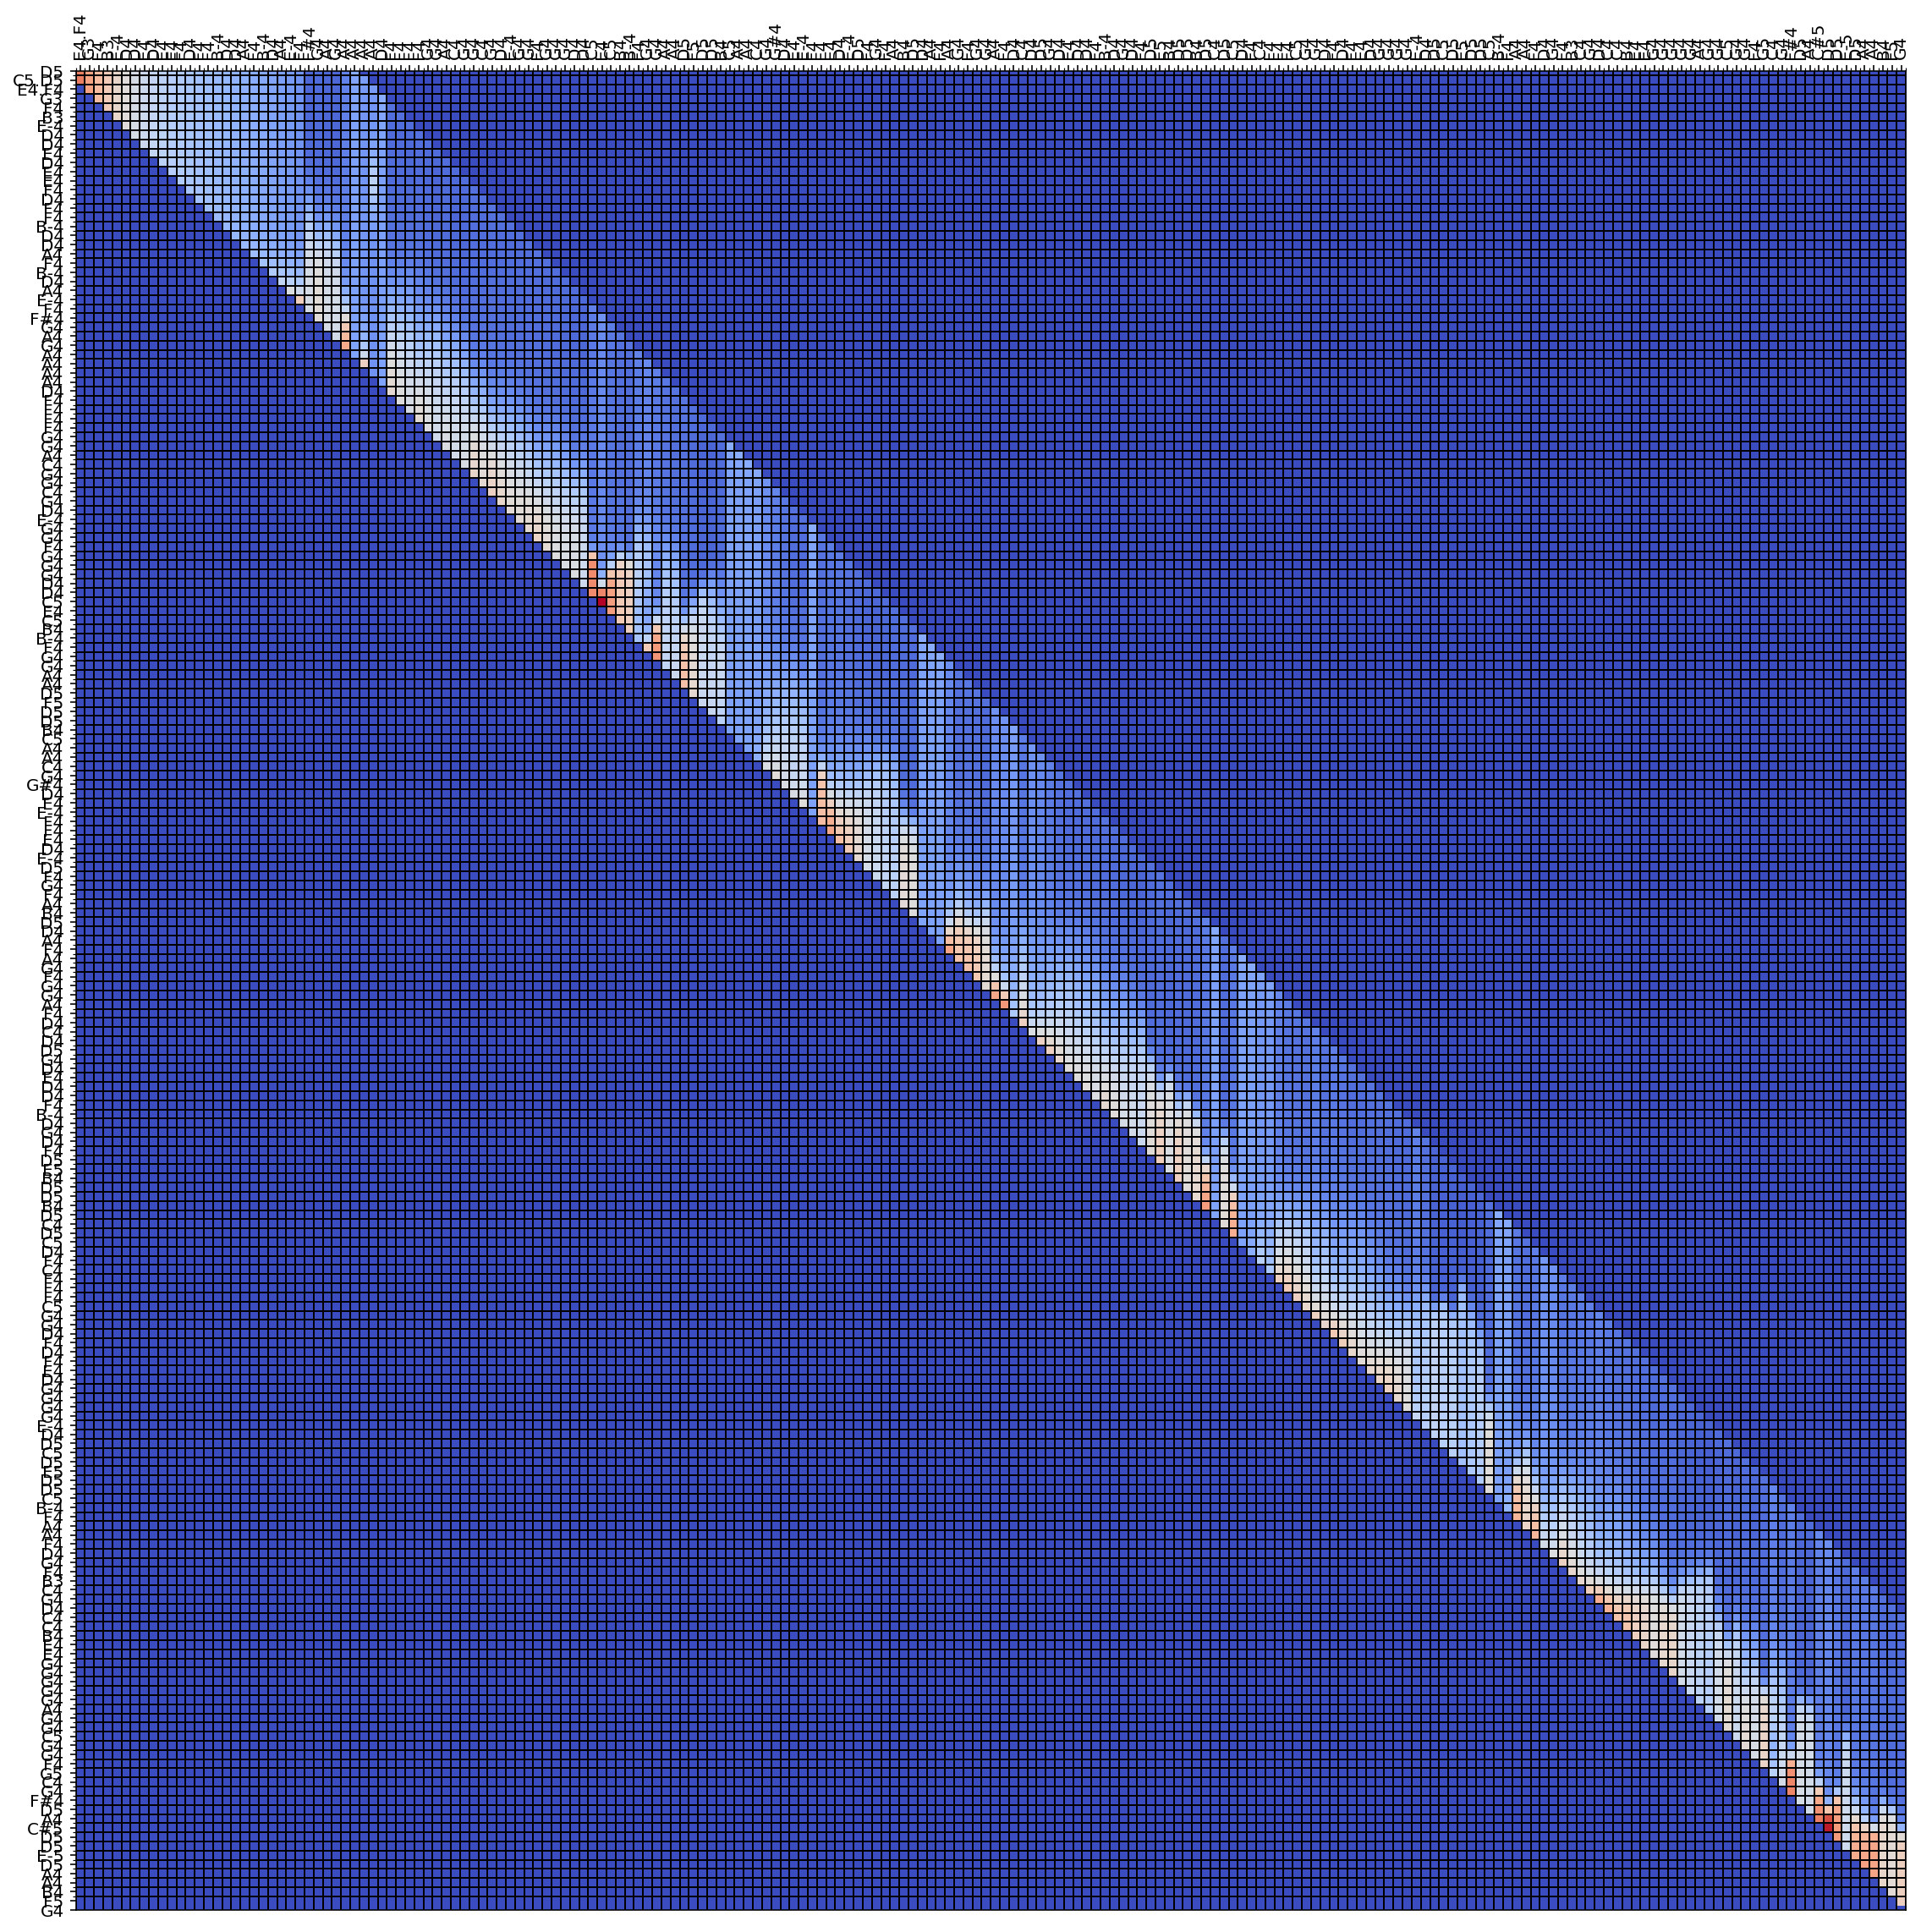

In [18]:
## attention plot
if use_attention:
    fig, ax = plt.subplots(figsize=(20,20))

    im = ax.imshow(att_matrix[(seq_len-2):,], cmap='coolwarm', interpolation='nearest')


    

    # Minor ticks
    ax.set_xticks(np.arange(-.5, len(prediction_output)- seq_len, 1), minor=True);
    ax.set_yticks(np.arange(-.5, len(prediction_output)- seq_len, 1), minor=True);

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    
    
    
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(prediction_output) - seq_len))
    ax.set_yticks(np.arange(len(prediction_output)- seq_len+2))
    # ... and label them with the respective list entries
    ax.set_xticklabels([n[0] for n in prediction_output[(seq_len):]])
    ax.set_yticklabels([n[0] for n in prediction_output[(seq_len - 2):]])

    # ax.grid(color='black', linestyle='-', linewidth=1)

    ax.xaxis.tick_top()


    
    plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va = "center",
             rotation_mode="anchor")

    plt.show()